# Bike Sharing Demand | Kaggle

In [1]:
# Install required packages & print variable descriptions

# Own custom functions
from training import *

# Other packages
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split

# Display options
plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Load variable definitions
df_desc=pd.read_excel('var_desc.xlsx')
with pd.option_context('expand_frame_repr', False):
    print("Variable definitions (Kaggle):")
    print(df_desc)

Variable definitions (Kaggle):
       Variable                                        Description
0      datetime                          hourly date + timestamp  
1        season      1 = spring, 2 = summer, 3 = fall, 4 = winter 
2       holiday            whether the day is considered a holiday
3   workingday    whether the day is neither a weekend nor holiday
4       weather  1: Clear, Few clouds, Partly cloudy, Partly cl...
5           NaN           2: Mist + Cloudy, Mist + Broken clouds, 
6           NaN                            Mist + Few clouds, Mist
7           NaN          3: Light Snow, Light Rain + Thunderstorm 
8           NaN  + Scattered clouds, Light Rain + Scattered clouds
9           NaN        4: Heavy Rain + Ice Pallets + Thunderstorm 
10          NaN                                + Mist, Snow + Fog 
11         temp                             temperature in Celsius
12        atemp                  feels like temperature in Celsius
13     humidity                

In [2]:
# Set meta information/parameters for (custom) training function
np.random.seed(42)

target                  = "count"
target_list             = ['count', 'registered', 'casual']
target_type             = "con"
val_size                = 0.2 
test_size               = 0.2
cv                      = True              
cv_folds                = 10            
scoring_cv              = "neg_root_mean_squared_error"  
training_alg            = "lgbm"
tune_hyperparameters    = False
final_scoring           = False
save_scoring_csv        = True


# Variable selection                                                                        Drop variable 
# Variable group                Included variables                                          [True | False]
varlist = [ 
["datetime",                    "datetime",                                                 True],
["season",                      ['season'],                                                 False],
["holiday",                     ['holiday'],                                                False],
["workingday",                  ['workingday'],                                             False],
["weather",                     ['weather'],                                                False],
["temp",                        ['temp'],                                                   True],
["atemp",                       ['atemp'],                                                  False],
["humidity",                    ['humidity'],                                               False],
["windspeed",                   ['windspeed'],                                              False],
["casual",                      ['casual'],                                                 True],
["registered",                  ['registered'],                                             True],
["weekday",                     ['weekday'],                                                False],
["day",                         ['day'],                                                    False],
["month",                       ['month'],                                                  False],
["year",                        ['year'],                                                   False],
["hour",                        ['hour'],                                                   False],
["hour_int",                    ['hour_int'],                                               True],
["hour_int_ind",                ['hour_int_evening', 'hour_int_maintime', 
                                'hour_int_morning', 'hour_int_night'],                      True],
["year_ind",                    ['year_2011', 'year_2012'],                                 True],
["month_ind",                   ['month_1', 'month_2', 'month_3','month_4', 'month_5', 
                                'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 
                                'month_11', 'month_12'],                                    True],
["season_ind",                  ['season_1', 'season_2', 'season_3', 'season_4'],           True],
["weather_ind",                 ['weather_1', 'weather_2', 'weather_3', 'weather_4'],       True],
["weekday_ind",                 ['weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 
                                'weekday_4', 'weekday_5', 'weekday_6'],                     True],
["year_quarter",                ['year_quarter'],                                           True],
["year_quarter_ind",            ['year_quarter_2011Q1', 'year_quarter_2011Q2',
                                'year_quarter_2011Q3', 'year_quarter_2011Q4', 
                                'year_quarter_2012Q1', 'year_quarter_2012Q2', 
                                'year_quarter_2012Q3', 'year_quarter_2012Q4'],              True],    
["count",                       ['count'],                                                  True]
]


# Create lists for variable selection/grouping
drop_train, drop_test  = drop_list(varlist), drop_list(varlist) # custom function

for i in target_list:
    drop_test.remove(i) 

category_list   = ['month', 'year', 'season', 'weather', 'weekday', 'year_quarter', 'hour_int']
numeric_list    = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
dt_list         = ['weekday', 'day', 'month', 'year', 'hour']

## Define Prep-Function for Train/Test

In [3]:
# Define date/time variables 
def data_preparation(df):
    
    # Generate additional features 
    df['datetime']          =   pd.to_datetime(df['datetime'].astype(str), format="%Y/%m/%d %H:%M:%S")
    df['year_quarter']      =   df['datetime'].dt.to_period('Q')
    df                      =   datetime_gen(df, dt_list) # custom function

    # Hour intervals
    df['hour_int']                                                          = 'night' 
    df.loc[(df['hour']  >= 4)   & (df['hour'] <10), 'hour_int']             = 'morning'
    df.loc[(df['hour']  >= 10)  & (df['hour'] <16), 'hour_int']             = 'maintime'
    df.loc[((df['hour'] >= 17)  & (df['hour'] <=23)) | ((df['hour'] >= 0) 
            & (df['hour'] <=3)), 'hour_int']                                = 'evening'

    # Generate dummies based on category_list
    for i in category_list:
        df = create_dummies(df, i)  # custom function
    return df 

## Load and Prepare Training Data

In [4]:
# Read training data
df = pd.read_csv('train_bike.csv')

# Apply data preparation function to training data
df = data_preparation(df)

# Take natural logarithm of dependent variable(s)
for i in target_list:
    df[i] = np.log(df[i]+1)

# Split dataset into train and test data
train, test = train_test_split(df, test_size = test_size)

## Modeling: Training, Hyperparameter-Tuning and Scoring

The average cross validation rmsle of the model is 0.28
[-0.26924939 -0.28148612 -0.27221893 -0.26138356 -0.26889409 -0.31742307
 -0.31101126 -0.270091   -0.29566948 -0.2923133 ]
0.2842729957281374


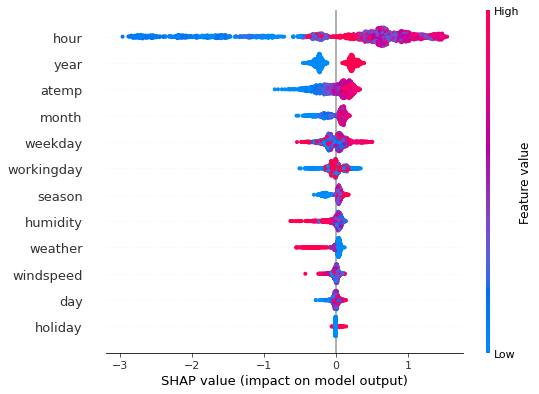

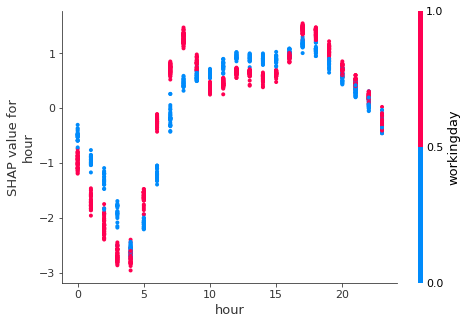

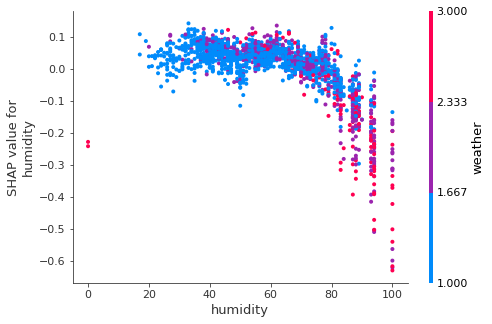

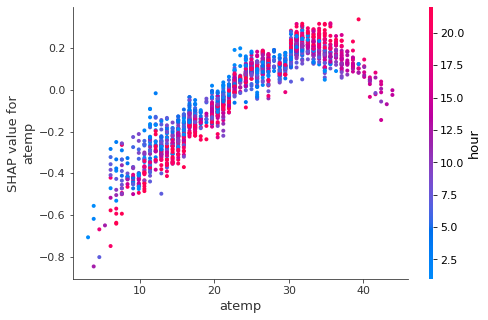

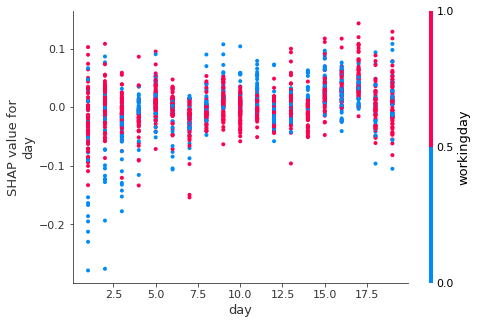

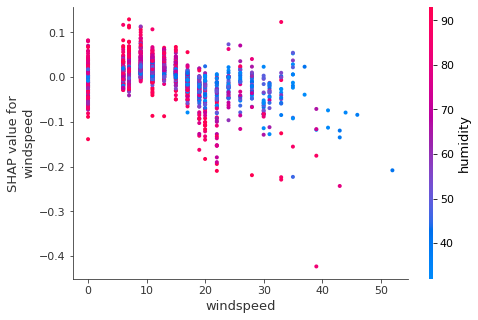

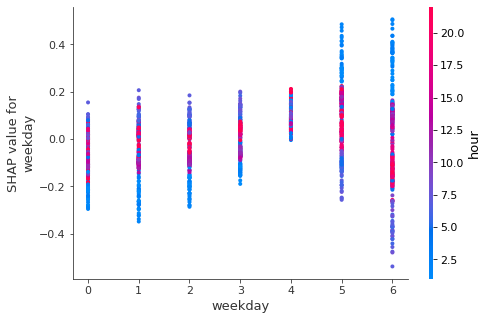

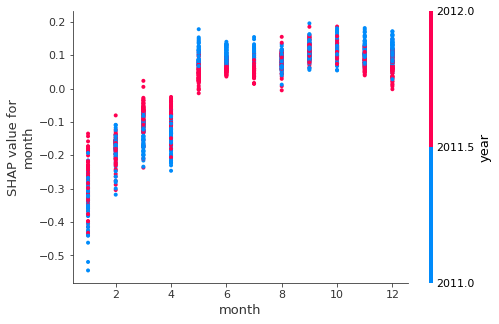

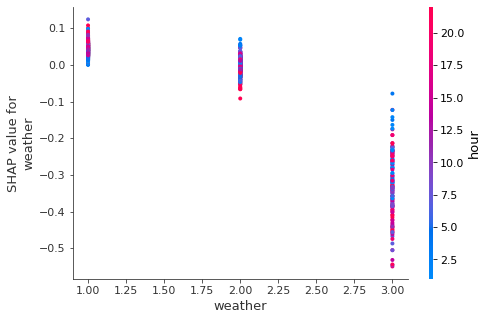

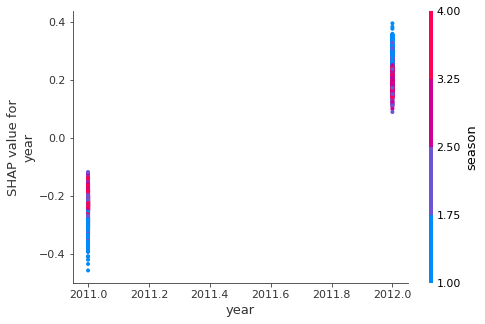

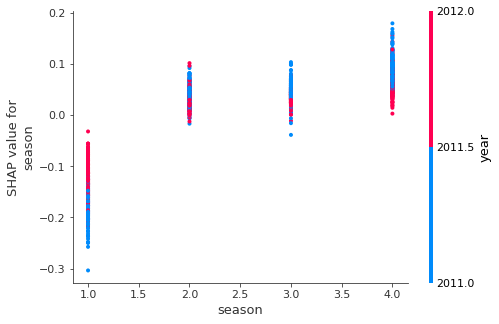

In [5]:
# (Untuned) LGBM | Kaggle Score: 0.42082 | Custom Function
      
fitted_model = training(   
                        train               =   train, 
                        test                =   test, 
                        validation_size     =   val_size,
                        final               =   final_scoring, 
                        estimator           =   training_alg, 
                        target_variable     =   target, 
                        drop_list           =   drop_train, 
                        target_type         =   target_type, 
                        cv                  =   cv, 
                        cv_folds            =   cv_folds, 
                        scoring_cv          =   scoring_cv, 
                        hypertuning         =   tune_hyperparameters 
                        )

## Load and Prepare Test Data, Score and Save Results

In [6]:
# If test data should be scored
if save_scoring_csv:
    
    # Load & prepare test data
    df              =   pd.read_csv('test_bike.csv')
    df              =   data_preparation(df)

    # Predict and generate required format
    df_x            =   df.drop(columns=drop_test)
    df[target]      =   np.exp(fitted_model.predict(df_x))-1
    df_final        =   df[['datetime', target]]

    # Write to .csv
    df_final.to_csv(f'results_{str(training_alg)}.csv', index = False)